<a href="https://colab.research.google.com/github/duongtrung/Pytorch-tutorials/blob/main/14_pytorch_multivariate_timeseries_forecasting_LSTM_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> 

In [92]:
# dataset: https://finance.yahoo.com/quote/GE/history/
# select Max in the Time Period if you want to get all datasets until your current date

In [55]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [70]:
df = pd.read_csv("data/GE-3months.csv")

In [71]:
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-10-27,107.879997,108.279999,103.690002,103.849998,103.414063,8984300
1,2021-10-28,103.389999,105.379997,103.099998,105.260002,104.818161,5910800
2,2021-10-29,104.949997,105.239998,104.120003,104.870003,104.429794,5618700
3,2021-11-01,105.760002,106.769997,105.279999,106.230003,105.784088,4887100
4,2021-11-02,106.339996,107.139999,105.300003,106.690002,106.242149,4480800


In [72]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,252.000000,252.000000,252.000000,252.000000,252.000000,2.520000e+02
mean,83.730675,84.845635,82.511746,83.657143,83.445877,6.696986e+06
std,13.882652,13.905495,13.732063,13.747321,13.627205,2.945638e+06
min,61.000000,61.160000,59.930000,61.090000,61.014286,3.269000e+06
25%,72.885000,73.830000,71.139999,72.725000,72.679544,4.980125e+06
50%,80.029999,81.525002,79.110000,80.509998,80.314315,6.147600e+06
75%,94.945001,96.064999,93.650002,94.922501,94.610777,7.606150e+06
max,114.730003,116.169998,110.480003,111.290001,110.822838,2.875490e+07


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       252 non-null    object 
 1   Open       252 non-null    float64
 2   High       252 non-null    float64
 3   Low        252 non-null    float64
 4   Close      252 non-null    float64
 5   Adj Close  252 non-null    float64
 6   Volume     252 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 13.9+ KB


In [74]:
# separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])

In [75]:
train_dates.head(5)

0   2021-10-27
1   2021-10-28
2   2021-10-29
3   2021-11-01
4   2021-11-02
Name: Date, dtype: datetime64[ns]

In [76]:
# variables for training
cols = list(df)[1:6] # ['Open', 'High', 'Low', 'Close', 'Adj Close']

In [77]:
df_for_training = df[cols].astype(float)

<AxesSubplot:>

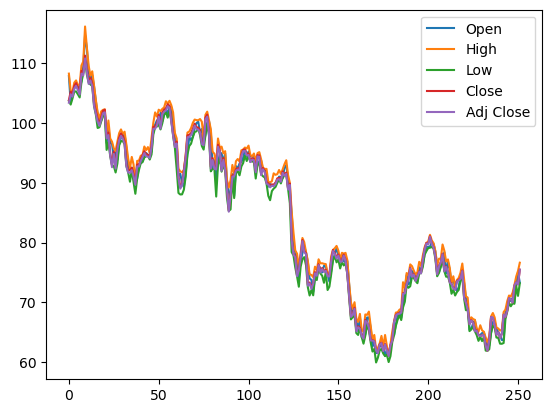

In [78]:
df_for_training.plot.line()

In [79]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [80]:
df_for_training_scaled.shape

(252, 5)

In [87]:
np.savetxt("data/GE_3months_scaled.csv", df_for_training_scaled, delimiter=',')

In [93]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

n_future = 2 # the th point in the future
n_past = 7

In [94]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

In [95]:
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (244, 7, 5).
trainY shape == (244, 1).


In [96]:
trainX[0], trainY[0]

(array([[1.74299417, 1.68861294, 1.54531784, 1.4717806 , 1.46823382],
        [1.41892543, 1.47964713, 1.50226691, 1.57455044, 1.57147526],
        [1.53151938, 1.4695592 , 1.57669381, 1.54612489, 1.54291916],
        [1.58998205, 1.57980654, 1.66133546, 1.64525013, 1.64249857],
        [1.63184352, 1.60646782, 1.66279509, 1.67877771, 1.67617918],
        [1.61885247, 1.5488219 , 1.62777062, 1.62629957, 1.6234606 ],
        [1.59792145, 1.55314576, 1.58909808, 1.57090591, 1.56781375]]),
 array([1.85270159]))

In [97]:
trainX[1], trainY[1]

(array([[1.41892543, 1.47964713, 1.50226691, 1.57455044, 1.57147526],
        [1.53151938, 1.4695592 , 1.57669381, 1.54612489, 1.54291916],
        [1.58998205, 1.57980654, 1.66133546, 1.64525013, 1.64249857],
        [1.63184352, 1.60646782, 1.66279509, 1.67877771, 1.67617918],
        [1.61885247, 1.5488219 , 1.62777062, 1.62629957, 1.6234606 ],
        [1.59792145, 1.55314576, 1.58909808, 1.57090591, 1.56781375],
        [1.67442747, 1.78733142, 1.77589387, 1.82819414, 1.82627983]]),
 array([2.23739812]))

In [98]:
trainX[2], trainY[2]

(array([[1.53151938, 1.4695592 , 1.57669381, 1.54612489, 1.54291916],
        [1.58998205, 1.57980654, 1.66133546, 1.64525013, 1.64249857],
        [1.63184352, 1.60646782, 1.66279509, 1.67877771, 1.67617918],
        [1.61885247, 1.5488219 , 1.62777062, 1.62629957, 1.6234606 ],
        [1.59792145, 1.55314576, 1.58909808, 1.57090591, 1.56781375],
        [1.67442747, 1.78733142, 1.77589387, 1.82819414, 1.82627983],
        [1.85270159, 1.83488884, 1.88315579, 1.80487056, 1.80284941]]),
 array([2.0764461]))